## AIM: Perform cluster analysis with extracted features, to see if features form clusters per diagnosis

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import mne
import os
%matplotlib widget
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_multitaper

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

### Loading in feature data

In [2]:
df_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features/df_stat_features.pkl')
df_features['age'] = df_features['age'].round().astype('Int32') # round age to nearest year and convert to int
df_features = df_features.dropna(subset=['diagnosis'])
df_features.sample(7)

,ID,age,gender,diagnosis,epoch,EO_frontal_delta_std,EO_frontal_delta_mean,EO_frontal_delta_median,EO_frontal_delta_skew,EO_frontal_delta_kurt,...,ratio_parietal_gamma_std,ratio_parietal_gamma_mean,ratio_parietal_gamma_median,ratio_parietal_gamma_skew,ratio_parietal_gamma_kurt,ratio_occipital_gamma_std,ratio_occipital_gamma_mean,ratio_occipital_gamma_median,ratio_occipital_gamma_skew,ratio_occipital_gamma_kurt
1766,sub-88010981,47,0.0,MDD,3,0.369105,-0.151640,-0.144236,-0.131465,0.050830,...,1.079675,1.141117,1.055052,1.066324,0.591562,1.049460,1.059466,1.044808,1.403818,3.107500
7532,sub-88073885,31,1.0,OCD,9,0.365099,-0.136190,-0.133982,-0.509107,0.413414,...,1.063561,1.114497,1.126137,1.070947,1.196163,1.011515,1.056950,1.141163,0.744583,0.399838
1051,sub-87974621,<NA>,0.0,HEALTHY,8,0.357375,-0.133293,-0.104790,-0.498082,0.209670,...,1.043029,1.096557,0.971602,1.078443,1.573847,1.023346,1.078077,0.962280,0.892464,1.386185
1831,sub-88012461,23,1.0,MDD,8,0.378992,-0.145457,-0.131951,-0.607113,0.738736,...,1.004008,0.934618,0.933285,2.746898,8.242091,1.027566,0.948896,0.880464,3.693493,10.291744
4321,sub-88044321,6,1.0,ADHD,2,0.354831,-0.135750,-0.120325,-0.396936,0.310529,...,0.846450,0.710873,0.749724,1.274894,2.154211,0.921438,0.857689,0.770604,0.975068,0.835092
2231,sub-88019393,63,0.0,MDD,12,0.380077,-0.149953,-0.145163,-0.369484,0.064582,...,1.012443,1.000077,0.952395,1.134307,1.574432,1.018097,1.055794,1.039147,0.775147,0.228428
6412,sub-88064565,51,0.0,MDD,5,0.387941,-0.158234,-0.157580,-0.335834,0.271054,...,1.105095,1.207235,1.257512,0.951504,0.789982,1.055257,1.162848,1.031317,0.719190,0.628521


In [3]:
df_features['diagnosis'].value_counts()

diagnosis
MDD        3732
ADHD       2051
SMC        1032
HEALTHY     564
OCD         540
Name: count, dtype: int64

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_features_ec = df_features[df_features.columns[~(df_features.columns.str.startswith('EO') | df_features.columns.str.startswith('ratio'))]]
df_features_eo = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('ratio'))]]
df_features_ratio = df_features[df_features.columns[~(df_features.columns.str.startswith('EC') | df_features.columns.str.startswith('EO'))]]

In [5]:
# channel groupings
frontal = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4']
central = ['T7', 'C3', 'Cz', 'C4', 'T8']
parietal = ['CP3','CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8'] 
occipital = ['O1', 'Oz', 'O2']
channel_groups = {'frontal': frontal, 'central': central, 'parietal': parietal, 'occipital': occipital}

# define (5) frequencies of interest for TFR per frequency band
delta = np.array([1, 1.5, 2, 2.5, 3]) # starting at one because of high-pass filter
theta = np.array([4, 4.75, 5.5, 6.25, 7])
alpha = np.array([8, 9, 10, 11, 12])
beta = np.array([13, 17.25, 21.5, 25.75, 30])
gamma = np.array([42, 54, 66, 78, 90]) 
bands = {'delta': delta, 'theta': theta, 'alpha': alpha, 'beta': beta, 'gamma': gamma}

# Cluster analysis
for each full 'ratio', 'ec', and 'eo' feature sets a cluster analysis will be performed with n_clusters = n_diagnoses (5)

#### Code for visualizations, taken from notebook of Anne van Duijvenbode (thanks)

In [8]:
## Define colors for plots in Hex and RGBA (/255)

hex_color1 = '#15234d'
hex_color2 = '#5675b2'
hex_color3 = '#dfe6ff'
hex_color4 = '#abacad'
hex_color5 = '#7393B3'
hex_color6 = '#5F9EA0'
hex_color7 = '#0F52BA'
hex_color8 = '#0818A8'


color1 = (21/ 255, 35/ 255, 77/ 255, 1)
color2 = (86/ 255, 117/ 255, 178/ 255, 1)
color3 = (223/ 255, 230/ 255, 255/ 255, 1)
color4 = (171/ 255, 172/ 255, 173/ 255, 1)
color5 = (115/ 255, 147/255, 179/255, 1)
color6 = (95/ 255, 158/ 255, 160/ 255, 1)
color7 = (15/ 255, 82/ 255, 186/ 255, 1)
color8 = (8/ 255, 24/ 255, 68/ 255, 1)

color_list = [[(21/ 255, 35/ 255, 77/ 255, 1)], 
              [(86/ 255, 117/ 255, 178/ 255, 1)],
             [(223/ 255, 230/ 255, 255/ 255, 1)],
             [(171/ 255, 172/ 255, 173/ 255, 1)]]

color_array = np.array([color1, color2, color3, color4, color5, color6, color7, color8])

# Library of Functions for the Open Classrooms Multivariate Exploratory Data Analysis Course 
## (derived from https://openclassrooms.com/en/courses/5869986-perform-an-exploratory-data-analysis)

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns


palette = sns.color_palette("bright", 10)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''
    cmap = 'Blues'

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
        
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
       
                plt.legend([1, 2, 3, 4, 5])

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

def append_class(df, class_name, feature, thresholds, names):
    '''Append a new class feature named 'class_name' based on a threshold split of 'feature'.  Threshold values are in 'thresholds' and class names are in 'names'.'''
    
    n = pd.cut(df[feature], bins = thresholds, labels=names)
    df[class_name] = n

def plot_dendrogram(Z, names, figsize=(10,25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.99, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax = plt.gca()
        ax.grid(alpha = 0.6)
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)  
        ax.tick_params(axis='x', labelrotation=90)


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle('Parallel coordinates plot centroids for {num_clusters} clusters'.format(num_clusters = num_clusters), fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color = [color1, color2, color4, color5])

    # Stagger the axes
    ax = plt.gca()
    ax.grid(True, alpha = 0.6)
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    
    ax.tick_params(axis='x', labelrotation=90)

#### ratio feature set

Text(0.5, 0.92, 'Cluster centers')

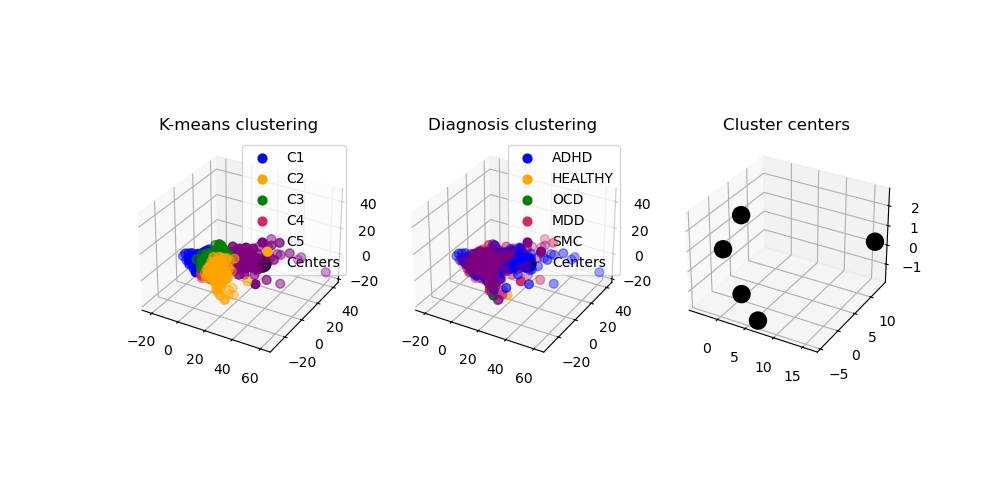

In [17]:
## K-means cluster analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

n_clusters = 5 # because 5 different classes/diagnoses

# define numeric columns
numeric_cols = []
for cond in ['ratio']:
    for band in bands:
        for group in channel_groups:
            for stat in ['std', 'mean', 'median', 'skew', 'kurt']:
                numeric_cols.append(f'{cond}_{group}_{band}_{stat}')
 
# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

X = df_features_ratio[numeric_cols]
X_scaled = numeric_transformer.fit_transform(X)
Y = df_features_ratio['diagnosis']

# model
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled_clustered['cluster'] = clusters

from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components = 3)
X_reduced = pca.fit_transform(X_scaled) # transfer to 2D

# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index = X.index, columns=['PC1','PC2', 'PC3'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

centres_reduced = pca.transform(kmeans.cluster_centers_)

%matplotlib widget
fig, ax = plt.subplots(1,3,figsize=(10,5),subplot_kw=dict(projection='3d'))

c1 = np.array(clusters==0)
c2 = np.array(clusters==1)
c3 = np.array(clusters==2)
c4 = np.array(clusters==3)
c5 = np.array(clusters==4)

d1 = np.array(Y=='ADHD')
d2 = np.array(Y=='HEALTHY')
d3 = np.array(Y=='OCD')
d4 = np.array(Y=='MDD')
d5 = np.array(Y=='SMC')



ax[0].scatter(X_reduced[c1,0],X_reduced[c1,1],X_reduced[c1,2],c='blue',s=40,label="C1", zorder=5)
ax[0].scatter(X_reduced[c2,0],X_reduced[c2,1],X_reduced[c2,2],c='orange',s=40,label="C2", zorder=4)
ax[0].scatter(X_reduced[c3,0],X_reduced[c3,1],X_reduced[c3,2],c='green',s=40,label="C3", zorder=3)
ax[0].scatter(X_reduced[c4,0],X_reduced[c4,1],X_reduced[c4,2],c='#D12B60',s=40,label="C4", zorder=2)
ax[0].scatter(X_reduced[c5,0],X_reduced[c5,1],X_reduced[c5,2],c='purple',s=40,label="C5", zorder=1)
ax[0].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[0].legend()
ax[0].set_title('K-means clustering')

ax[1].scatter(X_reduced[d1,0],X_reduced[d1,1],X_reduced[d1,2],c='blue',s=40,label="ADHD", zorder=5)
ax[1].scatter(X_reduced[d2,0],X_reduced[d2,1],X_reduced[d2,2],c='orange',s=40,label="HEALTHY", zorder=4)
ax[1].scatter(X_reduced[d3,0],X_reduced[d3,1],X_reduced[d3,2],c='green',s=40,label="OCD", zorder=3)
ax[1].scatter(X_reduced[d4,0],X_reduced[d4,1],X_reduced[d4,2],c='#D12B60',s=40,label="MDD", zorder=2)
ax[1].scatter(X_reduced[d5,0],X_reduced[d5,1],X_reduced[d5,2],c='purple',s=40,label="SMC", zorder=1)
ax[1].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[1].legend()
ax[1].set_title('Diagnosis clustering')

ax[2].scatter(centres_reduced[:,0],centres_reduced[:,1],centres_reduced[:,2],c="black",s=150,label="Centers",alpha=1)
ax[2].set_title('Cluster centers')

